In [108]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import convolve, generate_binary_structure
import matplotlib.patches as mpatches
from scipy.optimize import minimize_scalar
from PIL import Image, ImageDraw, ImageFont
import multiprocessing

In [102]:

@numba.njit("Tuple((f8[:], f8[:], f8[:,:], f8[:]))(f8[:,:], i8, f8, f8, i8)", nopython=True, nogil=True)
def metropolis(arr_spin, sweeps, beta, energy, N):
    times = sweeps * N ** 2
    arr_spin = arr_spin.copy()
    total_spin = np.zeros(sweeps)
    total_energy = np.zeros(sweeps)
    for t in range(0, times - 1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_t = arr_spin[x, y]
        spin_prime = -spin_t
        E_t = 0
        E_prime = 0
        neighbours = [(x - 1) % N, (x + 1) % N, (y - 1) % N, (y + 1) % N]
        for nx in [neighbours[0], neighbours[1]]:
            E_t += - spin_t * arr_spin[nx, y]
            E_prime += - spin_prime * arr_spin[nx, y]
        for ny in [neighbours[2], neighbours[3]]:
            E_t += - spin_t * arr_spin[x, ny]
            E_prime += - spin_prime * arr_spin[x, ny]
        dE = E_prime - E_t
        if (dE > 0) & (np.random.random() < np.exp(-beta * dE)):
            arr_spin[x, y] = spin_prime
            energy += dE
        elif dE <= 0:
            arr_spin[x, y] = spin_prime
            energy += dE
                
        if t % (N ** 2) == 0:
            total_spin[t // (N ** 2)] = arr_spin.sum()
            total_energy[t // (N ** 2)] = energy
    mag_squared = total_spin ** 2
        
    return total_spin, total_energy, arr_spin, mag_squared

/Users/danielmiksch/miniconda3/envs/juplab/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [121]:
def berechne_magnetization(t, N_array, betas, steps, sweeps):
    all_magnetizations = []
    for index1, i in enumerate(N_array):
        magnetization = np.zeros(len(betas))
        for index2, s in enumerate(betas):
            helpmodel = Isingmodel(N=i)
            grid = helpmodel.grid(i)
            energy = helpmodel.get_energy(grid)
            spins, energies, equilibrium, mag_squared = metropolis(grid, steps[index1], s, energy, i)
            magnetization[index2] = spins[-sweeps[index1]:].mean() / i ** 2
        all_magnetizations.append(magnetization)
    return all_magnetizations

In [122]:
class Isingmodel:
    def __init__(self, N=50, J=1, init=True):
        self.J = J
        self.N = N
        self.init = init
    
    def grid(self, N):
        init_random = np.random.random((N, N))
        if self.init:
            grid_n = np.ones((N, N))
        else:
            grid_n = np.zeros((N, N))
            grid_n[init_random >= .5] = 1
            grid_n[init_random < .5] = -1
        return grid_n
    
    def get_energy(self, grid):
        kernel = generate_binary_structure(2, 1)
        kernel[1][1] = False
        result = - self.J * grid * convolve(grid, kernel, mode='wrap')
        return result.sum()
    
    
    
    @staticmethod
    @numba.njit("Tuple((f8[:], f8[:], f8[:,:], f8[:]))(f8[:,:], i8, f8, f8, i8)", nopython=True, nogil=True)
    def metropolis(arr_spin, sweeps, beta, energy, N):
        times = sweeps * N ** 2
        arr_spin = arr_spin.copy()
        total_spin = np.zeros(sweeps)
        total_energy = np.zeros(sweeps)
        for t in range(0, times - 1):
            x = np.random.randint(0,N)
            y = np.random.randint(0,N)
            spin_t = arr_spin[x, y]
            spin_prime = -spin_t
            E_t = 0
            E_prime = 0
            neighbours = [(x - 1) % N, (x + 1) % N, (y - 1) % N, (y + 1) % N]
            for nx in [neighbours[0], neighbours[1]]:
                E_t += - spin_t * arr_spin[nx, y]
                E_prime += - spin_prime * arr_spin[nx, y]
            for ny in [neighbours[2], neighbours[3]]:
                E_t += - spin_t * arr_spin[x, ny]
                E_prime += - spin_prime * arr_spin[x, ny]
            dE = E_prime - E_t
            if (dE > 0) & (np.random.random() < np.exp(-beta * dE)):
                arr_spin[x, y] = spin_prime
                energy += dE
            elif dE <= 0:
                arr_spin[x, y] = spin_prime
                energy += dE
                
            if t % (N ** 2) == 0:
                total_spin[t // (N ** 2)] = arr_spin.sum()
                total_energy[t // (N ** 2)] = energy
        mag_squared = total_spin ** 2
        
        return total_spin, total_energy, arr_spin, mag_squared
        
    def plot(self, equilibrium, cmap, times, beta, save=False):
        fig, ax = plt.subplots(dpi=150)
        plt.rcParams["font.family"] = "times"
        plt.rcParams["text.usetex"] = True
        plt.title(fr'{self.N}$\times${self.N}-lattice after {times:.1e} sweeps ($N^2$ updates)' + '\n' + rf'$\beta={beta}$', fontsize=12, pad=10)
        ax.imshow(equilibrium, cmap=cmap, interpolation='none')
        white_patch = mpatches.Patch(color='white', label=r'$\sigma_i=-1$')
        black_patch = mpatches.Patch(color='black', label=r'$\sigma_i=+1$')

        legend = ax.legend(handles=[white_patch, black_patch], loc="upper right", bbox_to_anchor=(1.4, 1.02), fancybox=False, edgecolor='black', fontsize=12, facecolor='whitesmoke')
        legend.set_zorder(10)
        legend.get_frame().set_linewidth(0.5)
        plt.show()
        if save:
            fig.tight_layout()
            fig.savefig(f"/Users/danielmiksch/Downloads/{self.N}by{self.N}_grid.png")
            
    @staticmethod
    @numba.njit("f8[:,:,:](f8[:,:], i8, f8, f8, i8)", nopython=True, nogil=True)
    def animation(arr_spin, sweeps, beta, energy, N):
        times = sweeps * N ** 2
        arr_spin = arr_spin.copy()
        animation_arr = np.zeros((sweeps, N, N))
        for t in range(0, times - 1):
            x = np.random.randint(0,N)
            y = np.random.randint(0,N)
            spin_t = arr_spin[x, y]
            spin_prime = -spin_t
            E_t = 0
            E_prime = 0
            neighbours = [(x - 1) % N, (x + 1) % N, (y - 1) % N, (y + 1) % N]
            for nx in [neighbours[0], neighbours[1]]:
                E_t += - spin_t * arr_spin[nx, y]
                E_prime += - spin_prime * arr_spin[nx, y]
            for ny in [neighbours[2], neighbours[3]]:
                E_t += - spin_t * arr_spin[x, ny]
                E_prime += - spin_prime * arr_spin[x, ny]
            dE = E_prime - E_t
            if (dE > 0) & (np.random.random() < np.exp(-beta * dE)):
                arr_spin[x, y] = spin_prime
                energy += dE
            elif dE <= 0:
                arr_spin[x, y] = spin_prime
                energy += dE
                
            if t % (N ** 2) == 0:
                animation_arr[t // (N ** 2)] = arr_spin.copy()
                
        return animation_arr
    
    def save(self, frame_array, path, display_sweeps=True):
        pil_frames = []
        for i, frame in enumerate(frame_array):
            img = Image.fromarray(np.uint8(frame))
            b, _ = img.size
            if img.mode != 'RGB':
                img = img.convert('RGB')
            draw = ImageDraw.Draw(img)
            if display_sweeps:
                text = f"Sweeps: {i}"
                font = ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf", 20)
                draw.text((b // 2, 10), text, fill="red", font=font, anchor='mt')
            pil_frames.append(img)
                
        first_image = pil_frames[0]
        first_image.save(path, format='GIF', append_images=pil_frames[1:], save_all=True, duration=20, loop=0)
            
    def magnetization(self, spins):
        return spins / self.N ** 2
    
    def print_energy(self):
        print(self.get_energy(self.grid(self.N)))
        

    def get_magnetization(self, N_array, betas, steps, sweeps, iterations):
        magnetization_list = np.zeros((iterations * len(N_array), len(betas)))
        list_index = 0
        for t in range(0, iterations):
            for index1, i in enumerate(N_array):
                magnetization = np.zeros(len(betas))
                for index2, s in enumerate(betas):
                    spins, energies, equilibrium, mag_squared = self.metropolis(self.grid(i), steps[index1], s, self.get_energy(self.grid(i)), i)
                    magnetization[index2] = spins[-sweeps[index1]:].mean() / i ** 2
                magnetization_list[list_index] = magnetization
                list_index += 1
        magnetization_avg = np.zeros((len(N_array), len(betas)))
        for i in range(0, len(N_array)):
            group = range(i, len(magnetization_list), len(N_array))
            magnetization_avg[i] = np.mean(magnetization_list[group, :], axis=0)
        return magnetization_avg
    
    def get_susceptibility(self, N_array, betas, steps ,sweeps, iterations):
        variance_list = np.zeros((iterations * len(N_array), len(betas)))
        list_index = 0
        for t in range(0, iterations):
            for index1, i in enumerate(N_array):
                variance = np.zeros(len(betas))
                for index2, s in enumerate(betas):
                    spins, energies, equilibrium, mag_squared = self.metropolis(self.grid(i), steps[index1], s, self.get_energy(self.grid(i)), i)
                    variance[index2] = s * (mag_squared[-sweeps[index1]:].mean() - spins[-sweeps[index1]:].mean() ** 2) / i**2
                variance_list[list_index] = variance
                list_index += 1
        variance_avg = np.zeros((len(N_array), len(betas)))
        for i in range(0, len(N_array)):
            group = range(i, len(variance_list), len(N_array))
            variance_avg[i] = np.mean(variance_list[group, :], axis=0)
        return variance_avg

/Users/danielmiksch/miniconda3/envs/juplab/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/danielmiksch/miniconda3/envs/juplab/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [66]:
def log_interp1d(xx, yy, kind='quadratic'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

# a)
$50\times 50$-grid after $10\,000\cdot 50^2$ thermalization updates at $\beta=0.45$. The lattice is being initialized to the ferromagnetic ground state, i.e. all spins are equal to one.

In [123]:
N = 200
steps = 10e6 / N ** 2
beta = 0.4
model = Isingmodel(N=N)
spin_grid = model.grid(N)
energy = model.get_energy(spin_grid)

In [64]:
spins50, energies50, equilibrium50, variance50 = model.metropolis(spin_grid, steps, beta, energy, N)

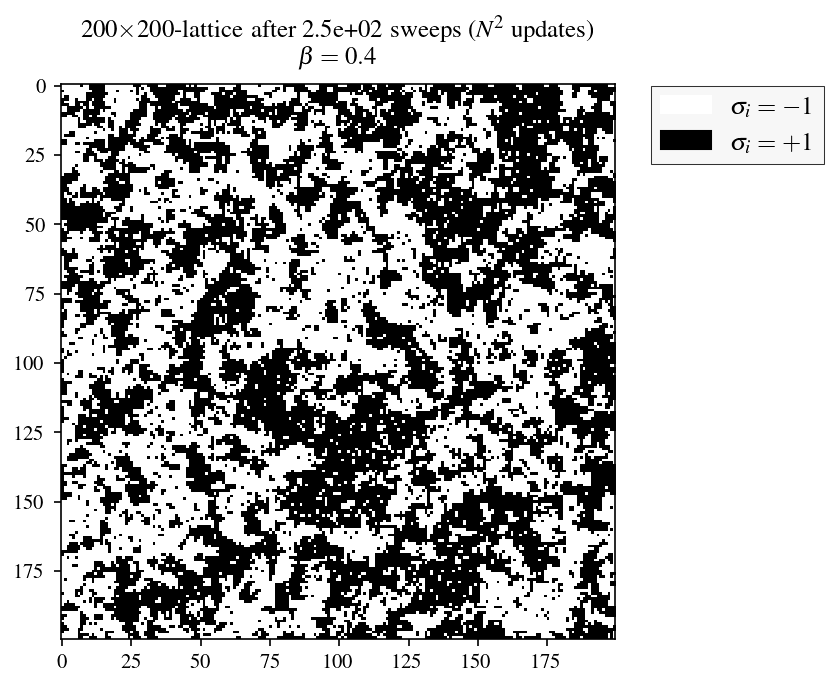

In [65]:
model.plot(equilibrium=equilibrium50, cmap='binary', times=steps, beta=beta, save=False)

# c)
The following code calculates the magnetisation with the metropolis algorithm for $N=20$ and $N=50$ on an interval of $\beta\in [0.3,0.7]$. To avoid fluctuation of the magnetization, the last $500\cdot N^2$ measurements are averaged.
The results of this computation are shown in the figure below. As one can see, the magnetization curve of the $50\times 50$-lattice are much smoother than the one of the $20\times 20$-lattice.
One reason for this is the size of the selected system. In most thermodynamic systems, the assumption is made that the system is infinite. A larger lattice has more spins that can interact. This leads to a larger number of microstates that determine the macro behavior of the system.
This results in fewer statistical fluctuations of the observables and thus a smoother magnetization curve.

In [125]:
betas = np.linspace(0.3, 0.7, 20)
N = [20, 50]
steps = [10000 for i in N]
sweeps = [500 for i in N]
model = Isingmodel()
magnetization = model.get_magnetization(N, betas, steps, sweeps, 1)

Process SpawnPoolWorker-57:
Traceback (most recent call last):
  File "/Users/danielmiksch/miniconda3/envs/juplab/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/danielmiksch/miniconda3/envs/juplab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/danielmiksch/miniconda3/envs/juplab/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/danielmiksch/miniconda3/envs/juplab/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'berechne_magnetization' on <module '__main__' (built-in)>
Process SpawnPoolWorker-67:
Process SpawnPoolWorker-66:
Process SpawnPoolWorker-64:
Process SpawnPoolWorker-61:
Process SpawnPoolWorker-63:
Process SpawnPoolWorker-65:
Process SpawnPoolWorker-62:
Process SpawnPoolWorker-60:
Process SpawnPoolWorker-59:
Process SpawnPoolWor

KeyboardInterrupt: 

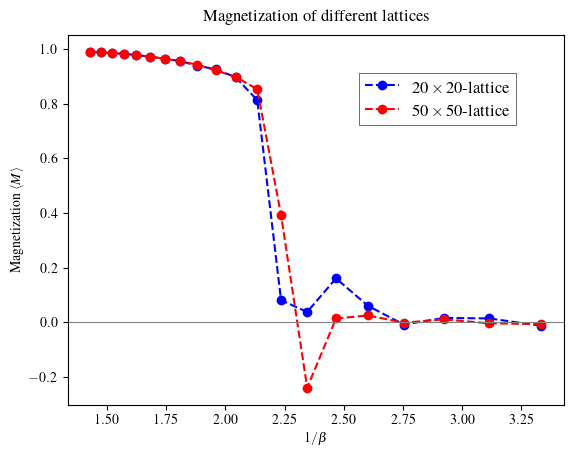

In [69]:
fig, ax = plt.subplots()

ax.plot(1 / betas, magnetization[0], 'o--', c='blue', label=r'$20\times20$-lattice')
ax.plot(1 / betas, magnetization[1], 'o--', c='red', label=r'$50\times50$-lattice')
ax.axhline(0, c='grey', linewidth=.8)
ax.set_xlabel(r'$1/\beta$')
ax.set_ylabel(r'Magnetization $\langle M\rangle$')
plt.title('Magnetization of different lattices', fontsize=12, pad=10)

legend = ax.legend(loc="upper right", bbox_to_anchor=(0.92, 0.92), fancybox=False, edgecolor='black', fontsize=12)
legend.set_zorder(10)
legend.get_frame().set_linewidth(0.5)

plt.show()

# fig.savefig(f"/Users/danielmiksch/Downloads/magnetization.pdf")

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(12,4))
# 
# plt.rcParams["font.family"] = "times"
# plt.rcParams["text.usetex"] = True
# 
# ax = axes[0]
# ax.plot(spins/50**2)
# ax.set_xlabel('Algorithm Time Steps')
# ax.set_ylabel(r'Magnetization $\langle M\rangle$')
# ax.grid()
# ax = axes[1]
# ax.plot(energies)
# ax.set_xlabel('Algorithm Time Steps')
# ax.set_ylabel(r'Energy $E$')
# ax.grid()
# fig.tight_layout()
# fig.suptitle(r'Evolution of Average Spin and Energy', y=1.07, size=18)
# plt.show()

# d)
This part of the code calculates the variance of the magnetization (or spins). The calculations are performed according to the following formula:
\begin{equation}
\operatorname{Var}\left(M\right)=\left\langle M^2\right\rangle-\left\langle M\right\rangle^2 \quad \text{with}\quad M=\sum_{i} \sigma_i
\end{equation}
The variance is then being normalized with the factor $\beta/N^2$, wich gives us the susceptibility $\chi$:
\begin{equation}
\chi=\frac{\beta}{N^2}\left(\left\langle M^2\right\rangle-\left\langle M\right\rangle^2\right)
\end{equation}
Numerous sweep passes ($600\cdot N^2$) are also used here to minimize the fluctuations of the observables.
As one can see, the calculations with the bigger lattice, i.e. 50 by 50, allows much more precise statements to be made about the susceptibility curve and the critical temperature than with the smaller grid.

In [95]:
betas = np.linspace(0.3, 0.7, 20)
N = [60]
steps = [2000 for i in N]
sweeps = [200 for i in N]
testmodel = Isingmodel()
variance = testmodel.get_susceptibility(N, betas, steps, sweeps, 2)

In [96]:
# interp_variance50 = log_interp1d(betas, variance[1])
interp_variance20 = log_interp1d(betas, variance[0])

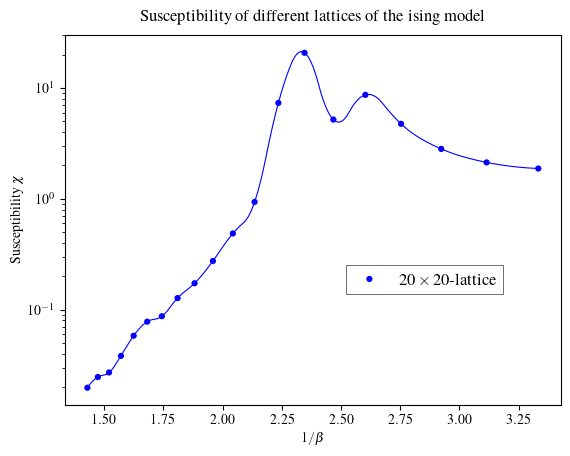

In [97]:
fig, ax = plt.subplots()

x = np.linspace(0.3, 0.7, 1000)

# ax.plot(1 / x, interp_variance50(x),
#          c='red',
#          linewidth=.8,
#          label='',
#          zorder=2)
ax.plot(1 / x, interp_variance20(x),
         c='blue',
         linewidth=.8,
         label='',
         zorder=2)
ax.scatter(1 / betas, variance[0], label=r'$20\times20$-lattice', marker='.', s=80, edgecolors='none', color='blue')
# ax.scatter(1 / betas, variance[1], label=r'$50\times50$-lattice', marker='.', s=80, edgecolors='none', color='red')
ax.set_yscale('log')

ax.set_xlabel(r'$1/\beta$')
ax.set_ylabel(r'Susceptibility $\chi$')
plt.title('Susceptibility of different lattices of the ising model', fontsize=12, pad=10)

legend = ax.legend(loc="upper right", bbox_to_anchor=(0.9, 0.4), fancybox=False, edgecolor='black', fontsize=12)
legend.set_zorder(10)
legend.get_frame().set_linewidth(0.5)

plt.show()

# fig.savefig(f"/Users/danielmiksch/Downloads/susceptibility.pdf")

# e)

In [73]:
susceptibility = np.array([[4.23637318e+00, 6.48776817e+00, 9.21784376e+00, 2.02425153e+01,
        1.92234617e+01, 1.87984785e+01, 7.40000379e+00, 5.29998396e+00,
        1.17735125e+00, 1.44203712e+00, 2.42426470e-01, 2.02178901e-01,
        1.26060607e-01, 1.23729902e-01, 5.06868538e-02, 6.12197150e-02,
        4.47886637e-02, 3.49408299e-02, 1.94462317e-02, 1.69449796e-02],
       [5.47339810e+00, 6.80279635e+00, 8.78538560e+00, 1.09256116e+01,
        1.41011402e+01, 4.31103823e+01, 2.08770825e+02, 1.46301852e+01,
        2.36193879e+00, 6.90456768e-01, 2.90349619e-01, 2.52328388e-01,
        1.63122408e-01, 1.13570352e-01, 6.45294475e-02, 4.80211902e-02,
        4.15942776e-02, 2.95113955e-02, 2.49789672e-02, 1.99977009e-02]])

In [74]:
interp_susceptibility50 = log_interp1d(betas, susceptibility[1])

In [75]:
beta_crit = minimize_scalar(lambda x: -interp_susceptibility50(x), bounds=(0.3, 0.7), method='bounded')
beta_crit = beta_crit.x
kb = 1.380649e-23

In [76]:
(1 / beta_crit) / kb

1.7080732825345923e+23

# Animation

In [267]:
N = 400
sweeps = 4000
beta = 0.57
model = Isingmodel(N=N)
spin_grid = model.grid(N)
energy = model.get_energy(spin_grid)

In [268]:
animation = model.metropolis(spin_grid, sweeps, beta, energy, N)

In [269]:
# model.save(animation, path='/Users/danielmiksch/Downloads/new.gif', display_sweeps=True)

# Improvements

In [55]:
N = 300
sweeps = 500
beta = 0.5
model = isingmodel_fast(N=N, init=False)
spin_grid = model.grid(N)
energy = model.get_energy(spin_grid)
animation = model.animation(spin_grid, sweeps, beta, energy, N)
model.save(animation, path='/Users/danielmiksch/Downloads/300grid.gif', display_sweeps=True)